In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import keras
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from keras import Sequential
from scipy import ndimage 
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, ReLU
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix

In [ ]:
!unzip "/content/drive/My Drive/Final_Folder.zip" -d "/content"

# Define Helper Functions


## Filenames and Labels Array Helper

In [ ]:
def generate(GANs):
  train_dir = '/content/Cropped_Folder'
  filenames = []
  labels = []
  root_counter = 0

  for i in range(len(GANs)):
    GANs[i] = '/content/Cropped_Folder/Cropped_' + GANs[i]

  for root, dirs, files in os.walk(train_dir, topdown=False):
    if root in GANs:
      for f in files:
        if root + '/' + f == '/content/Cropped_Folder/Cropped_WGAN/.DS_Store':
          continue
        filenames.append(root + '/' + f)
        labels.append(root_counter)
      root_counter += 1
  
  return filenames, labels

## Custom Generator

In [ ]:
class Generator(Sequence):
  
    def __init__(self, filenames, labels, batch_size=32):
        self.filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self) :
        epoch_length = np.floor(len(self.filenames))
        return (epoch_length / float(self.batch_size)).astype(np.int)
  
    def __getitem__(self, idx) :
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
    
        batch_x = self.filenames[start: end]
        batch_y = self.labels[start: end]
    
        X = np.zeros((self.batch_size, 178, 178, 3))
        
        for i in range(self.batch_size):
            X[i, :, :, :] = np.array(imread(batch_x[i], plugin='matplotlib')/255.0)[:, :, :3]
        
        y = np.array(to_categorical(batch_y))
        return X, y        

## Minibatch Std. Dev. Layer

In [ ]:
### MinibatchStdDev implementation from https://machinelearningmastery.com/how-to-train-a-progressive-growing-gan-in-keras-for-synthesizing-faces/
from math import sqrt
from keras import backend
from keras.layers import Layer

class MinibatchStdev(Layer):
	def __init__(self, **kwargs):
		super(MinibatchStdev, self).__init__(**kwargs)
 
	def call(self, inputs):
		mean = backend.mean(inputs, axis=0, keepdims=True)
		squ_diffs = backend.square(inputs - mean)
		mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
		mean_sq_diff += 1e-8
		stdev = backend.sqrt(mean_sq_diff)
		mean_pix = backend.mean(stdev, keepdims=True)
		shape = backend.shape(inputs)
		output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
		combined = backend.concatenate([inputs, output], axis=-1)
		return combined
 
	def compute_output_shape(self, input_shape):
		input_shape = list(input_shape)
		input_shape[-1] += 1
		return tuple(input_shape)

# Classification on CelebFaces, PGGAN, StyleGAN

## Load Dataset

In [ ]:
filenames, labels = generate(['CelebFaces', 'PGGAN', 'StyleGAN'])
filenames_shuffled, labels_shuffled = shuffle(filenames, labels)
X_train, X_test, y_train, y_test = train_test_split(filenames_shuffled, labels_shuffled, test_size = 0.2, random_state = 42)
training_gen = Generator(X_train, y_train)

In [ ]:
n_images = 10000
X_train_np = np.zeros((n_images, 178, 178, 3))

print('.... Loading Images From Files ....')
for i in range(n_images):
  X_train_np[i, :, :, :] = np.array(imread(X_train[i])/255.0)[:, :, :3]
  if i%1000 == 0:
    print('iteration', i)

y_train_np = to_categorical(y_train)

.... Loading Images From Files ....
iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000


## Baseline CNN 

In [ ]:
model3 = Sequential()

model3.add(Conv2D(32,(3,3),input_shape = (178,178,3), padding='same',))
model3.add(ReLU())
model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(ReLU())
model3.add(MaxPool2D((2, 2)))

model3.add(Conv2D(128, (3, 3), padding='same'))
model3.add(ReLU())
model3.add(MaxPool2D((2, 2)))

model3.add(Flatten())

model3.add(Dense(128, activation = 'relu'))
model3.add(Dense(3, activation='sigmoid'))

model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history3 = model3.fit(X_train_np, y_train_np, epochs=10, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 14s 24ms/step - loss: 0.4122 - accuracy: 0.6342 - val_loss: 0.3072 - val_accuracy: 0.7680
Epoch 2/10
250/250 [==============================] - 5s 21ms/step - loss: 0.2696 - accuracy: 0.8029 - val_loss: 0.2209 - val_accuracy: 0.8515
Epoch 3/10
250/250 [==============================] - 5s 21ms/step - loss: 0.1473 - accuracy: 0.9121 - val_loss: 0.1396 - val_accuracy: 0.9090
Epoch 4/10
250/250 [==============================] - 5s 21ms/step - loss: 0.0645 - accuracy: 0.9649 - val_loss: 0.1026 - val_accuracy: 0.9480
Epoch 5/10
250/250 [==============================] - 5s 21ms/step - loss: 0.0279 - accuracy: 0.9866 - val_loss: 0.0916 - val_accuracy: 0.9515
Epoch 6/10
250/250 [==============================] - 5s 21ms/step - loss: 0.0144 - accuracy: 0.9941 - val_loss: 0.0969 - val_accuracy: 0.9530
Epoch 7/10
250/250 [==============================] - 5s 21ms/step - loss: 0.0092 - accuracy: 0.9955 - val_loss: 0.1196 - val_accuracy: 0.946

In [ ]:
model3.save('/content/drive/My Drive/model_linear')

INFO:tensorflow:Assets written to: /content/drive/My Drive/model_linear/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_linear/assets


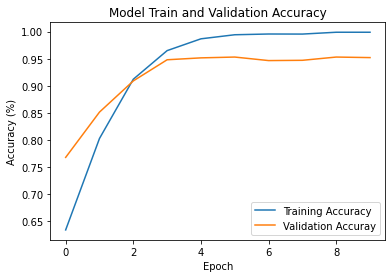

In [ ]:
plt.plot(history3.history['accuracy'], label = 'Training Accuracy')
plt.plot(history3.history['val_accuracy'], label = 'Validation Accuray')
plt.title('Model Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

## Dropout + L2 CNN

In [ ]:
model4 = Sequential()

model4.add(Conv2D(32,(3,3),input_shape = (178,178,3), padding='same',))
model4.add(ReLU())
model4.add(MaxPool2D(pool_size=(2,2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(64, (3, 3), padding='same'))
model4.add(ReLU())
model4.add(MaxPool2D((2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(128, (3, 3), padding='same'))
model4.add(ReLU())
model4.add(MaxPool2D((2, 2)))
model4.add(Dropout(0.2))

model4.add(Flatten())

model4.add(Dense(128, activation = 'relu', kernel_regularizer = l2 (l = 0.0004)))
model4.add(Dense(3, activation='sigmoid'))

model4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history4 = model4.fit(X_train_np, y_train_np, epochs=20, validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 7s 26ms/step - loss: 0.4822 - accuracy: 0.6114 - val_loss: 0.3607 - val_accuracy: 0.6540
Epoch 2/20
250/250 [==============================] - 6s 24ms/step - loss: 0.3337 - accuracy: 0.7471 - val_loss: 0.3187 - val_accuracy: 0.7780
Epoch 3/20
250/250 [==============================] - 6s 24ms/step - loss: 0.2875 - accuracy: 0.8110 - val_loss: 0.2615 - val_accuracy: 0.8415
Epoch 4/20
250/250 [==============================] - 6s 24ms/step - loss: 0.2319 - accuracy: 0.8739 - val_loss: 0.2078 - val_accuracy: 0.9005
Epoch 5/20
250/250 [==============================] - 6s 24ms/step - loss: 0.1828 - accuracy: 0.9145 - val_loss: 0.1777 - val_accuracy: 0.9285
Epoch 6/20
250/250 [==============================] - 6s 24ms/step - loss: 0.1569 - accuracy: 0.9362 - val_loss: 0.1539 - val_accuracy: 0.9375
Epoch 7/20
250/250 [==============================] - 6s 23ms/step - loss: 0.1375 - accuracy: 0.9484 - val_loss: 0.1409 - val_accuracy: 0.9425

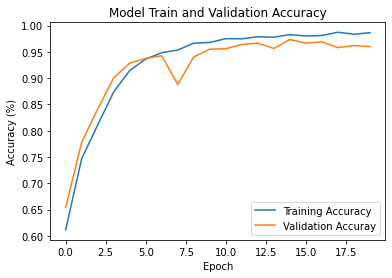

In [ ]:
plt.plot(history4.history['accuracy'], label = 'Training Accuracy')
plt.plot(history4.history['val_accuracy'], label = 'Validation Accuray')
plt.title('Model Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

## (3x3) Laplacian Filter

In [ ]:
model5 = Sequential()

model5.add(Conv2D(32,(3,3), padding='same',))
model5.add(ReLU())
model5.add(MaxPool2D(pool_size=(2,2)))
model5.add(Dropout(0.2))

model5.add(Conv2D(64, (3, 3), padding='same'))
model5.add(ReLU())
model5.add(MaxPool2D((2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv2D(128, (3, 3), padding='same'))
model5.add(ReLU())
model5.add(MaxPool2D((2, 2)))
model5.add(Dropout(0.2))

model5.add(Flatten())

model5.add(Dense(128, activation = 'relu', kernel_regularizer = l2 (l=0.0003)))
model5.add(Dense(3, activation='sigmoid'))

model5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
from scipy import ndimage

n_images = 10000
X_train_np = np.zeros((n_images, 178, 178, 3))

kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])

print('.... Loading Images From Files ....')
for i in range(n_images):
  img0 = np.array(imread(X_train[i])/255.0)[:, :, 0]
  img1 = np.array(imread(X_train[i])/255.0)[:, :, 1]
  img2 = np.array(imread(X_train[i])/255.0)[:, :, 2]
  X_train_np[i, :, :, 0] = ndimage.convolve(img0, kernel, mode='constant')
  X_train_np[i, :, :, 1] = ndimage.convolve(img1, kernel, mode='constant')
  X_train_np[i, :, :, 2] = ndimage.convolve(img2, kernel, mode='constant')
  if i%1000 == 0:
    print('iteration', i)

y_train_np = to_categorical(y_train)

.... Loading Images From Files ....
iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000


In [ ]:
history5 = model5.fit(X_train_np, y_train_np, batch_size=30, epochs=10, validation_split=0.2)

Epoch 1/10
267/267 [==============================] - 8s 27ms/step - loss: 0.4394 - accuracy: 0.7228 - val_loss: 0.2905 - val_accuracy: 0.8345
Epoch 2/10
267/267 [==============================] - 6s 23ms/step - loss: 0.1898 - accuracy: 0.9179 - val_loss: 0.1498 - val_accuracy: 0.9455
Epoch 3/10
267/267 [==============================] - 6s 23ms/step - loss: 0.0978 - accuracy: 0.9749 - val_loss: 0.0830 - val_accuracy: 0.9830
Epoch 4/10
267/267 [==============================] - 6s 23ms/step - loss: 0.0675 - accuracy: 0.9883 - val_loss: 0.0714 - val_accuracy: 0.9845
Epoch 5/10
267/267 [==============================] - 6s 23ms/step - loss: 0.0469 - accuracy: 0.9958 - val_loss: 0.0653 - val_accuracy: 0.9845
Epoch 6/10
267/267 [==============================] - 6s 23ms/step - loss: 0.0492 - accuracy: 0.9924 - val_loss: 0.0631 - val_accuracy: 0.9830
Epoch 7/10
267/267 [==============================] - 6s 23ms/step - loss: 0.0460 - accuracy: 0.9935 - val_loss: 0.0485 - val_accuracy: 0.9935

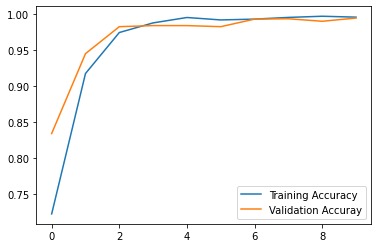

In [ ]:
plt.plot(history5.history['accuracy'], label = 'Training Accuracy')
plt.plot(history5.history['val_accuracy'], label = 'Validation Accuray')
plt.legend()

In [ ]:
model5.save('/content/drive/My Drive/sharpening_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/sharpening_model/assets


## (5x5) Laplacian Filter

In [ ]:
model6 = Sequential()

model6.add(Conv2D(32,(3,3), padding='same',))
model6.add(ReLU())
model6.add(MaxPool2D(pool_size=(2,2)))
model6.add(Dropout(0.2))

model6.add(Conv2D(64, (3, 3), padding='same'))
model6.add(ReLU())
model6.add(MaxPool2D((2, 2)))
model6.add(Dropout(0.2))

model6.add(Conv2D(128, (3, 3), padding='same'))
model6.add(ReLU())
model6.add(MaxPool2D((2, 2)))
model6.add(Dropout(0.2))

model6.add(Flatten())

model6.add(Dense(128, activation = 'relu', kernel_regularizer = l2 (l=0.0003)))
model6.add(Dense(3, activation='sigmoid'))

model6.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
from scipy import ndimage

n_images = 10000
X_train_np = np.zeros((n_images, 178, 178, 3))

kernel = np.array(
[[-1, -1, -1, -1, -1],
[-1, 1, 2, 1, -1],
[-1, 2, 4, 2, -1],
[-1, 1, 2, 1, -1],
[-1, -1, -1, -1, -1]])

print('.... Loading Images From Files ....')
for i in range(n_images):
  img0 = np.array(imread(X_train[i])/255.0)[:, :, 0]
  img1 = np.array(imread(X_train[i])/255.0)[:, :, 1]
  img2 = np.array(imread(X_train[i])/255.0)[:, :, 2]
  X_train_np[i, :, :, 0] = ndimage.convolve(img0, kernel, mode='constant')
  X_train_np[i, :, :, 1] = ndimage.convolve(img1, kernel, mode='constant')
  X_train_np[i, :, :, 2] = ndimage.convolve(img2, kernel, mode='constant')
  if i%1000 == 0:
    print('iteration', i)

y_train_np = to_categorical(y_train)

.... Loading Images From Files ....
iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000


In [ ]:
history5 = model6.fit(X_train_np, y_train_np, batch_size=30, epochs=10, validation_split=0.2)

Epoch 1/10
267/267 [==============================] - 8s 26ms/step - loss: 0.4886 - accuracy: 0.6952 - val_loss: 0.2945 - val_accuracy: 0.8340
Epoch 2/10
267/267 [==============================] - 6s 23ms/step - loss: 0.2253 - accuracy: 0.8917 - val_loss: 0.1585 - val_accuracy: 0.9410
Epoch 3/10
267/267 [==============================] - 6s 23ms/step - loss: 0.1346 - accuracy: 0.9513 - val_loss: 0.1268 - val_accuracy: 0.9575
Epoch 4/10
267/267 [==============================] - 6s 23ms/step - loss: 0.1061 - accuracy: 0.9729 - val_loss: 0.0951 - val_accuracy: 0.9760
Epoch 5/10
267/267 [==============================] - 6s 23ms/step - loss: 0.0815 - accuracy: 0.9834 - val_loss: 0.1020 - val_accuracy: 0.9660
Epoch 6/10
267/267 [==============================] - 6s 23ms/step - loss: 0.0704 - accuracy: 0.9880 - val_loss: 0.0749 - val_accuracy: 0.9840
Epoch 7/10
267/267 [==============================] - 6s 23ms/step - loss: 0.0665 - accuracy: 0.9895 - val_loss: 0.0771 - val_accuracy: 0.9830

In [ ]:
model6.save('/content/drive/My Drive/large_high_pass')

INFO:tensorflow:Assets written to: /content/drive/My Drive/large_high_pass/assets


## (3x3) Gaussian Smoothing Filter

In [ ]:
model7 = Sequential()

model7.add(Conv2D(32,(3,3), padding='same',))
model7.add(ReLU())
model7.add(MaxPool2D(pool_size=(2,2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(64, (3, 3), padding='same'))
model7.add(ReLU())
model7.add(MaxPool2D((2, 2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(128, (3, 3), padding='same'))
model7.add(ReLU())
model7.add(MaxPool2D((2, 2)))
model7.add(Dropout(0.2))

model7.add(Flatten())

model7.add(Dense(128, activation = 'relu', kernel_regularizer = l2 (l=0.0003)))
model7.add(Dense(3, activation='sigmoid'))

model7.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
from scipy import ndimage

n_images = 10000
X_train_np = np.zeros((n_images, 178, 178, 3))

kernel = np.array([[1, 2, 1],
                   [2,  4, 2],
                   [1, 2, 1]])/16

print('.... Loading Images From Files ....')
for i in range(n_images):
  img0 = np.array(imread(X_train[i])/255.0)[:, :, 0]
  img1 = np.array(imread(X_train[i])/255.0)[:, :, 1]
  img2 = np.array(imread(X_train[i])/255.0)[:, :, 2]
  X_train_np[i, :, :, 0] = ndimage.convolve(img0, kernel, mode='constant')
  X_train_np[i, :, :, 1] = ndimage.convolve(img1, kernel, mode='constant')
  X_train_np[i, :, :, 2] = ndimage.convolve(img2, kernel, mode='constant')
  if i%1000 == 0:
    print('iteration', i)

y_train_np = to_categorical(y_train)

.... Loading Images From Files ....
iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000


In [ ]:
history7 = model7.fit(X_train_np, y_train_np, batch_size=30, epochs=20, validation_split=0.2)

Epoch 1/20
267/267 [==============================] - 15s 26ms/step - loss: 0.6002 - accuracy: 0.5281 - val_loss: 0.3740 - val_accuracy: 0.7170
Epoch 2/20
267/267 [==============================] - 6s 23ms/step - loss: 0.3504 - accuracy: 0.7186 - val_loss: 0.3288 - val_accuracy: 0.7300
Epoch 3/20
267/267 [==============================] - 6s 23ms/step - loss: 0.3098 - accuracy: 0.7684 - val_loss: 0.3124 - val_accuracy: 0.7495
Epoch 4/20
267/267 [==============================] - 6s 23ms/step - loss: 0.2873 - accuracy: 0.7999 - val_loss: 0.3080 - val_accuracy: 0.7810
Epoch 5/20
267/267 [==============================] - 6s 23ms/step - loss: 0.2600 - accuracy: 0.8291 - val_loss: 0.2555 - val_accuracy: 0.8440
Epoch 6/20
267/267 [==============================] - 6s 23ms/step - loss: 0.2288 - accuracy: 0.8601 - val_loss: 0.2135 - val_accuracy: 0.8800
Epoch 7/20
267/267 [==============================] - 6s 23ms/step - loss: 0.1945 - accuracy: 0.8960 - val_loss: 0.1862 - val_accuracy: 0.910

In [ ]:
model7.save('/content/drive/My Drive/low_pass_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/low_pass_model/assets


## Gaussian + Laplacian Filter

In [ ]:
model8 = Sequential()

model8.add(Conv2D(32,(3,3), padding='same',))
model8.add(ReLU())
model8.add(MaxPool2D(pool_size=(2,2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(64, (3, 3), padding='same'))
model8.add(ReLU())
model8.add(MaxPool2D((2, 2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(128, (3, 3), padding='same'))
model8.add(ReLU())
model8.add(MaxPool2D((2, 2)))
model8.add(Dropout(0.2))

model8.add(Flatten())

model8.add(Dense(128, activation = 'relu', kernel_regularizer = l2 (l=0.0003)))
model8.add(Dense(3, activation='sigmoid'))

model8.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
from scipy import ndimage

n_images = 10000
X_train_np = np.zeros((n_images, 178, 178, 6))

low_kernel = np.array([[1, 2, 1],
                   [2,  4, 2],
                   [1, 2, 1]])/9

high_kernel = np.array([[1, 1, 1],
                        [1, -8, 1],
                        [1, 1, 1]])

print('.... Loading Images From Files ....')
for i in range(n_images):
  img0 = np.array(imread(X_train[i])/255.0)[:, :, 0]
  img1 = np.array(imread(X_train[i])/255.0)[:, :, 1]
  img2 = np.array(imread(X_train[i])/255.0)[:, :, 2]
  X_train_np[i, :, :, 0] = ndimage.convolve(img0, low_kernel, mode='constant')
  X_train_np[i, :, :, 1] = ndimage.convolve(img1, low_kernel, mode='constant')
  X_train_np[i, :, :, 2] = ndimage.convolve(img2, low_kernel, mode='constant')
  X_train_np[i, :, :, 3] = ndimage.convolve(img0, high_kernel, mode='constant')
  X_train_np[i, :, :, 4] = ndimage.convolve(img1, high_kernel, mode='constant')
  X_train_np[i, :, :, 5] = ndimage.convolve(img2, high_kernel, mode='constant')
  if i%1000 == 0:
    print('iteration', i)

y_train_np = to_categorical(y_train)

.... Loading Images From Files ....
iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000


In [ ]:
history8 = model8.fit(X_train_np, y_train_np, batch_size=30, epochs=20, validation_split=0.2)

Epoch 1/20
267/267 [==============================] - 10s 35ms/step - loss: 0.4760 - accuracy: 0.6831 - val_loss: 0.3285 - val_accuracy: 0.8005
Epoch 2/20
267/267 [==============================] - 7s 28ms/step - loss: 0.2774 - accuracy: 0.8329 - val_loss: 0.2296 - val_accuracy: 0.8625
Epoch 3/20
267/267 [==============================] - 7s 28ms/step - loss: 0.1788 - accuracy: 0.9139 - val_loss: 0.1257 - val_accuracy: 0.9500
Epoch 4/20
267/267 [==============================] - 7s 28ms/step - loss: 0.1214 - accuracy: 0.9554 - val_loss: 0.0876 - val_accuracy: 0.9745
Epoch 5/20
267/267 [==============================] - 7s 28ms/step - loss: 0.0938 - accuracy: 0.9682 - val_loss: 0.0916 - val_accuracy: 0.9690
Epoch 6/20
267/267 [==============================] - 7s 27ms/step - loss: 0.0790 - accuracy: 0.9787 - val_loss: 0.0715 - val_accuracy: 0.9795
Epoch 7/20
267/267 [==============================] - 7s 27ms/step - loss: 0.0737 - accuracy: 0.9812 - val_loss: 0.0749 - val_accuracy: 0.979

In [ ]:
model8.save('/content/drive/My Drive/high_low_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/high_low_model/assets


## MiniBatch Std. Dev. + 3x3 Laplacian

In [ ]:
from scipy import ndimage

n_images = 10000
X_train_np = np.zeros((n_images, 178, 178, 3))

kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])

print('.... Loading Images From Files ....')
for i in range(n_images):
  img0 = np.array(imread(X_train[i])/255.0)[:, :, 0]
  img1 = np.array(imread(X_train[i])/255.0)[:, :, 1]
  img2 = np.array(imread(X_train[i])/255.0)[:, :, 2]
  X_train_np[i, :, :, 0] = ndimage.convolve(img0, kernel, mode='constant')
  X_train_np[i, :, :, 1] = ndimage.convolve(img1, kernel, mode='constant')
  X_train_np[i, :, :, 2] = ndimage.convolve(img2, kernel, mode='constant')
  if i%1000 == 0:
    print('iteration', i)

y_train_np = to_categorical(y_train)

.... Loading Images From Files ....
iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000


In [ ]:
model8 = Sequential()

model8.add(Conv2D(32,(3,3), padding='same',))
model8.add(ReLU())
model8.add(MaxPool2D(pool_size=(2,2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(64, (3, 3), padding='same'))
model8.add(ReLU())
model8.add(MaxPool2D((2, 2)))
model8.add(Dropout(0.2))

model8.add(MinibatchStdev())

model8.add(Conv2D(128, (3, 3), padding='same'))
model8.add(ReLU())
model8.add(MaxPool2D((2, 2)))
model8.add(Dropout(0.2))

model8.add(Flatten())

model8.add(Dense(128, activation = 'relu', kernel_regularizer = l2 (l=0.0003)))
model8.add(Dense(3, activation='sigmoid'))

model8.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history8 = model8.fit(X_train_np, y_train_np, batch_size=30, epochs=20, validation_split=0.2)

Epoch 1/20
267/267 [==============================] - 9s 30ms/step - loss: 0.4624 - accuracy: 0.6824 - val_loss: 0.2924 - val_accuracy: 0.8350
Epoch 2/20
267/267 [==============================] - 7s 25ms/step - loss: 0.2269 - accuracy: 0.8758 - val_loss: 0.1390 - val_accuracy: 0.9455
Epoch 3/20
267/267 [==============================] - 7s 25ms/step - loss: 0.1117 - accuracy: 0.9536 - val_loss: 0.0816 - val_accuracy: 0.9795
Epoch 4/20
267/267 [==============================] - 7s 25ms/step - loss: 0.0727 - accuracy: 0.9797 - val_loss: 0.0612 - val_accuracy: 0.9860
Epoch 5/20
267/267 [==============================] - 7s 25ms/step - loss: 0.0520 - accuracy: 0.9885 - val_loss: 0.0619 - val_accuracy: 0.9830
Epoch 6/20
267/267 [==============================] - 7s 25ms/step - loss: 0.0523 - accuracy: 0.9887 - val_loss: 0.0549 - val_accuracy: 0.9880
Epoch 7/20
267/267 [==============================] - 7s 25ms/step - loss: 0.0420 - accuracy: 0.9937 - val_loss: 0.0561 - val_accuracy: 0.9820

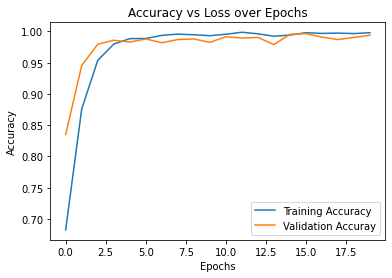

In [ ]:
plt.plot(history8.history['accuracy'], label = 'Training Accuracy')
plt.plot(history8.history['val_accuracy'], label = 'Validation Accuray')
plt.title('Accuracy vs Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
model8.save('/content/drive/My Drive/minibatchstddev')

INFO:tensorflow:Assets written to: /content/drive/My Drive/minibatchstddev/assets


## Standard Deviations Exploration

In [ ]:
filenames, labels = generate(['CelebFaces', 'PGGAN', 'StyleGAN'])
filenames_shuffled, labels_shuffled = shuffle(filenames, labels)
X_train, X_test, y_train, y_test = train_test_split(filenames_shuffled, labels_shuffled, test_size = 0.2, random_state = 42)
training_gen = Generator(X_train, y_train)

In [ ]:
StyleGAN = [X_train[i] for i in np.where(np.in1d(y_train, 0))[0]]
CelebA = [X_train[i] for i in np.where(np.in1d(y_train, 1))[0]]
PGGAN = [X_train[i] for i in np.where(np.in1d(y_train, 2))[0]]

In [ ]:
StyleGAN_np = np.zeros((len(StyleGAN), 178, 178, 3))

kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])

for i in range(len(StyleGAN)):
  img0 = np.array(imread(StyleGAN[i])/255.0)[:, :, 0]
  img1 = np.array(imread(StyleGAN[i])/255.0)[:, :, 1]
  img2 = np.array(imread(StyleGAN[i])/255.0)[:, :, 2]
  StyleGAN_np[i, :, :, 0] = ndimage.convolve(img0, kernel, mode='constant')
  StyleGAN_np[i, :, :, 1] = ndimage.convolve(img1, kernel, mode='constant')
  StyleGAN_np[i, :, :, 2] = ndimage.convolve(img2, kernel, mode='constant')
Style_mean = np.mean(StyleGAN_np, axis=0)
Style_sq_diff = np.square(StyleGAN_np - Style_mean)
Style_mean_sq_diff = np.mean(Style_sq_diff, axis=0)
Style_mean_sq_diff += 1e-8
Style_std = np.sqrt(Style_mean_sq_diff)

In [ ]:
Style_norm = (Style_std - np.min(Style_std)) / (np.max(Style_std) - np.min(Style_std))

In [ ]:
print(np.mean(Style_std))

0.5706469565672996


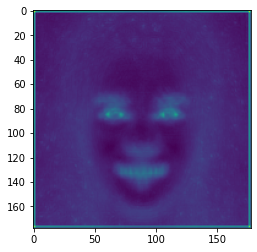

In [ ]:
plt.imshow(np.mean(Style_norm, axis=2))

In [ ]:
PGGAN_np = np.zeros((len(PGGAN), 178, 178, 3))
for i in range(len(PGGAN)):
  img0 = np.array(imread(PGGAN[i])/255.0)[:, :, 0]
  img1 = np.array(imread(PGGAN[i])/255.0)[:, :, 1]
  img2 = np.array(imread(PGGAN[i])/255.0)[:, :, 2]
  PGGAN_np[i, :, :, 0] = ndimage.convolve(img0, kernel, mode='constant')
  PGGAN_np[i, :, :, 1] = ndimage.convolve(img1, kernel, mode='constant')
  PGGAN_np[i, :, :, 2] = ndimage.convolve(img2, kernel, mode='constant')
PG_mean = np.mean(PGGAN_np, axis=0)
PG_sq_diff = np.square(PGGAN_np - PG_mean)
PG_mean_sq_diff = np.mean(PG_sq_diff, axis=0)
PG_mean_sq_diff += 1e-8
PG_std = np.sqrt(PG_mean_sq_diff)

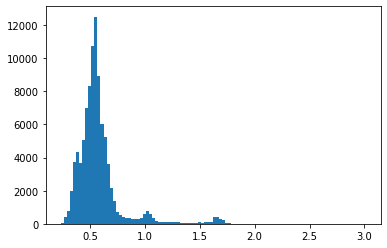

In [ ]:
plt.hist(PG_std.ravel(), bins=100)
plt.show()

In [ ]:
print(np.mean(PG_std))

0.5796905879912594


In [ ]:
PG_norm = (PG_std - np.min(PG_std)) / (np.max(PG_std) - np.min(PG_std))

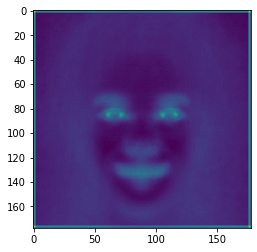

In [ ]:
plt.imshow(np.mean(PG_norm, axis=2))

In [ ]:
Celeb_np = np.zeros((len(CelebA), 178, 178, 3))
for i in range(len(CelebA)):
  img0 = np.array(imread(CelebA[i])/255.0)[:, :, 0]
  img1 = np.array(imread(CelebA[i])/255.0)[:, :, 1]
  img2 = np.array(imread(CelebA[i])/255.0)[:, :, 2]
  Celeb_np[i, :, :, 0] = ndimage.convolve(img0, kernel, mode='constant')
  Celeb_np[i, :, :, 1] = ndimage.convolve(img1, kernel, mode='constant')
  Celeb_np[i, :, :, 2] = ndimage.convolve(img2, kernel, mode='constant')
Celeb_mean = np.mean(Celeb_np, axis=0)
Celeb_sq_diff = np.square(Celeb_np - PG_mean)
Celeb_mean_sq_diff = np.mean(Celeb_sq_diff, axis=0)
Celeb_mean_sq_diff += 1e-8
Celeb_std = np.sqrt(Celeb_mean_sq_diff)

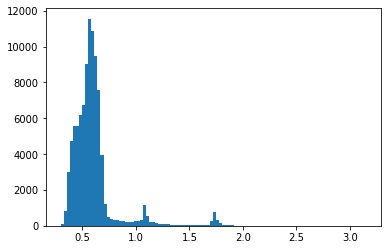

In [ ]:
plt.hist(Celeb_std.ravel(), bins=100)
plt.show()

In [ ]:
print(np.mean(Celeb_std))

0.6031462356580046


In [ ]:
Celeb_norm = (Celeb_std - np.min(Celeb_std)) / (np.max(Celeb_std) - np.min(Celeb_std))

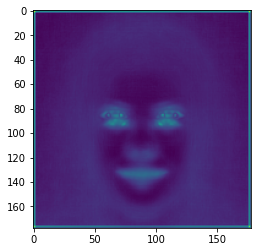

In [ ]:
plt.imshow(np.mean(Celeb_std, axis=2))

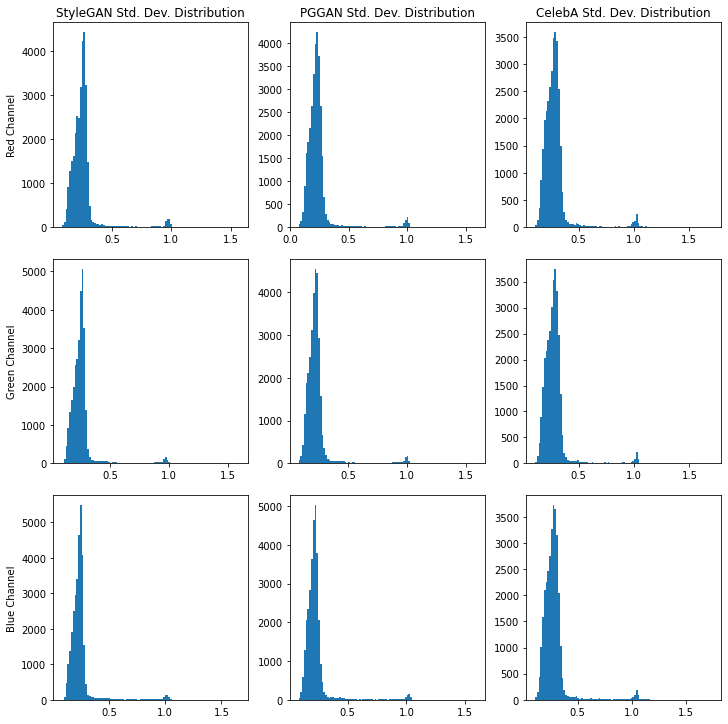

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))
plt.tight_layout()

ax[0, 0].set_title('StyleGAN Std. Dev. Distribution')
ax[0, 0].set_ylabel('Red Channel')
ax[1, 0].set_ylabel('Green Channel')
ax[2, 0].set_ylabel('Blue Channel')
ax[0, 0].hist(Style_std[:, :, 0].ravel(), bins = 100)
ax[1, 0].hist(Style_std[:, :, 1].ravel(), bins = 100)
ax[2, 0].hist(Style_std[:, :, 2].ravel(), bins = 100)
ax[0, 1].set_title('PGGAN Std. Dev. Distribution')
ax[0, 1].hist(PG_std[:, :, 0].ravel(), bins = 100)
ax[1, 1].hist(PG_std[:, :, 1].ravel(), bins = 100)
ax[2, 1].hist(PG_std[:, :, 2].ravel(), bins = 100)
ax[0, 2].set_title('CelebA Std. Dev. Distribution')
ax[0, 2].hist(Celeb_std[:, :, 0].ravel(), bins = 100)
ax[1, 2].hist(Celeb_std[:, :, 1].ravel(), bins = 100)
ax[2, 2].hist(Celeb_std[:, :, 2].ravel(), bins = 100)

plt.show()
